<a href="https://colab.research.google.com/github/OkBruh1234/Earthquake_Prediction-Project/blob/main/HI_Model_Train_best_run.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df=pd.read_csv('/content/drive/MyDrive/Datasets/reanalysis-era5-land-timeseries-sfc-2m-temperaturej63zxwd9.csv')
df.head()

,valid_time,d2m,t2m,latitude,longitude
0,1965-01-01 00:00:00,277.02142,287.11840,28.2,74.0
1,1965-01-01 01:00:00,277.14197,286.74790,28.2,74.0
2,1965-01-01 02:00:00,277.26782,286.19660,28.2,74.0
3,1965-01-01 03:00:00,277.49630,286.91495,28.2,74.0
4,1965-01-01 04:00:00,278.23267,289.36713,28.2,74.0


In [3]:
df1 = pd.read_csv('/content/drive/MyDrive/Datasets/reanalysis-era5-land-timeseries-sfc-pressure-precipitationn1pegznh.csv')
df2 = pd.read_csv('/content/drive/MyDrive/Datasets/reanalysis-era5-land-timeseries-sfc-radiation-heatcdm4ojvn.csv')
df3 = pd.read_csv('/content/drive/MyDrive/Datasets/reanalysis-era5-land-timeseries-sfc-windstkafutv.csv')
df1.head(), df2.head(), df3.head()

(            valid_time         sp        tp  latitude  longitude
 0  1965-01-01 00:00:00  98421.310  0.000000      28.2       74.0
 1  1965-01-01 01:00:00  98426.140  0.000000      28.2       74.0
 2  1965-01-01 02:00:00  98464.125  0.000000      28.2       74.0
 3  1965-01-01 03:00:00  98522.375  0.000027      28.2       74.0
 4  1965-01-01 04:00:00  98599.340  0.000241      28.2       74.0,
             valid_time      ssrd  latitude  longitude
 0  1965-01-01 00:00:00       0.0      28.2       74.0
 1  1965-01-01 01:00:00       0.0      28.2       74.0
 2  1965-01-01 02:00:00       0.0      28.2       74.0
 3  1965-01-01 03:00:00  235450.0      28.2       74.0
 4  1965-01-01 04:00:00  766432.0      28.2       74.0,
             valid_time       u10       v10  latitude  longitude
 0  1965-01-01 00:00:00 -2.816071  2.193237      28.2       74.0
 1  1965-01-01 01:00:00 -2.629517  2.225680      28.2       74.0
 2  1965-01-01 02:00:00 -2.475174  2.290512      28.2       74.0
 3  1965-01-

In [4]:
import pandas as pd
# Load individual CSVs
df = pd.read_csv('/content/drive/MyDrive/Datasets/reanalysis-era5-land-timeseries-sfc-2m-temperaturej63zxwd9.csv')
df1 = pd.read_csv('/content/drive/MyDrive/Datasets/reanalysis-era5-land-timeseries-sfc-pressure-precipitationn1pegznh.csv')
df2 = pd.read_csv('/content/drive/MyDrive/Datasets/reanalysis-era5-land-timeseries-sfc-radiation-heatcdm4ojvn.csv')
df3 = pd.read_csv('/content/drive/MyDrive/Datasets/reanalysis-era5-land-timeseries-sfc-windstkafutv.csv')

# Rename columns for clarity
temperature_df = df.rename(columns={"t2m": "temperature_K", "d2m": "dewpoint_K"})
pressure_precip_df = df1.rename(columns={"sp": "surface_pressure"})
radiation_df = df2.rename(columns={"ssrd": "solar_radiation"})
wind_df = df3.rename(columns={"u10": "wind_u", "v10": "wind_v"})

# Merge on timestamp + location
merged_df = temperature_df.merge(pressure_precip_df, on=["valid_time", "latitude", "longitude"])
merged_df = merged_df.merge(radiation_df, on=["valid_time", "latitude", "longitude"])
merged_df = merged_df.merge(wind_df, on=["valid_time", "latitude", "longitude"])

# Save final merged CSV
merged_df.to_csv("/content/drive/MyDrive/Datasets/merged_era5_stage1_dataset.csv", index=False)

In [5]:
merged_df
merged_df.shape

(530712, 10)

In [6]:
import pandas as pd
import numpy as np

# Load your merged dataset
df = pd.read_csv("/content/drive/MyDrive/Datasets/merged_era5_stage1_dataset.csv")

# Convert temperature from Kelvin to Celsius
df['temperature_C'] = df['temperature_K'] - 273.15
df['dewpoint_C'] = df['dewpoint_K'] - 273.15

# Calculate Relative Humidity
def calculate_rh(temp_c, dewpoint_c):
    return 100 * (np.exp((17.625 * dewpoint_c) / (243.04 + dewpoint_c)) /
                  np.exp((17.625 * temp_c) / (243.04 + temp_c)))

df['RH'] = df.apply(lambda row: calculate_rh(row['temperature_C'], row['dewpoint_C']), axis=1)

# Calculate Heat Index (Rothfusz regression - NOAA)
def calculate_hi(temp_c, rh):
    T = temp_c * 9/5 + 32  # Celsius to Fahrenheit
    HI = (-42.379 + 2.04901523*T + 10.14333127*rh
          - 0.22475541*T*rh - 6.83783e-3*T**2
          - 5.481717e-2*rh**2 + 1.22874e-3*T**2*rh
          + 8.5282e-4*T*rh**2 - 1.99e-6*T**2*rh**2)
    return (HI - 32) * 5/9  # Fahrenheit to Celsius

df['HI_C'] = df.apply(lambda row: calculate_hi(row['temperature_C'], row['RH']), axis=1)

# Check a sample
display(df[['valid_time', 'temperature_C', 'dewpoint_C', 'RH', 'HI_C']].head())

,valid_time,temperature_C,dewpoint_C,RH,HI_C
0,1965-01-01 00:00:00,13.96840,3.87142,50.582269,30.316291
1,1965-01-01 01:00:00,13.59790,3.99197,52.254649,30.876531
2,1965-01-01 02:00:00,13.04660,4.11782,54.646807,31.730964
3,1965-01-01 03:00:00,13.76495,4.34630,52.990234,30.626443
4,1965-01-01 04:00:00,16.21713,5.08267,47.642503,27.628977


In [7]:
# Step 3A: Preprocessing

# 1. Convert datetime
df['valid_time'] = pd.to_datetime(df['valid_time'])

# 2. Sort chronologically
df = df.sort_values('valid_time')

# 3. Drop duplicate timestamps (if any)
df = df.drop_duplicates(subset='valid_time')

# 4. Check for missing/null values
print("Nulls before fill/drop:")
print(df.isnull().sum())

# 5. Drop or fill missing values (depends on strategy, we'll drop for now)
df = df.dropna()

# 6. Optional sanity checks
df = df[df['RH'] <= 100]  # RH cannot be above 100%
df = df[df['temperature_C'] > -50]  # Exclude unrealistic temps

print("✅ Preprocessing done. Shape:", df.shape)

Nulls before fill/drop:
valid_time          0
dewpoint_K          0
temperature_K       0
latitude            0
longitude           0
surface_pressure    0
tp                  0
solar_radiation     0
wind_u              0
wind_v              0
temperature_C       0
dewpoint_C          0
RH                  0
HI_C                0
dtype: int64
✅ Preprocessing done. Shape: (530702, 14)


In [8]:
# 📌 This comes right after preprocessing step (df already cleaned)

# ✅ Convert valid_time to datetime & set as index
df['valid_time'] = pd.to_datetime(df['valid_time'])
df.set_index('valid_time', inplace=True)

# 🔁 Resample hourly data to daily averages
df = df.resample('D').mean().reset_index()

# ⏪ Add lag features for daily forecasting
df['HI_C_lag1'] = df['HI_C'].shift(1)
df['temperature_C_lag1'] = df['temperature_C'].shift(1)
df['RH_lag1'] = df['RH'].shift(1)

# 🧹 Drop rows with missing values (from lagging)
df = df.dropna().reset_index(drop=True)

# ✅ Confirm shape and preview
print("✅ Daily-level feature engineering complete. Shape:", df.shape)
df.head()
df.shape

✅ Daily-level feature engineering complete. Shape: (22112, 17)


(22112, 17)

In [9]:
df.dropna(inplace=True)  # Safe to do before scaling


In [10]:
# 🔁 Extract month from valid_time
df['month'] = pd.to_datetime(df['valid_time']).dt.month

# 🔥 Filter only summer months (March to June)
df['month'] = df['valid_time'].dt.month
df = df[df['month'].between(3, 7)]


# 🚨 Create a binary classification label: 1 if HI_C >= 40 (heatwave), else 0
df['is_heatwave'] = df['HI_C'].apply(lambda x: 1 if x >= 40 else 0)

# 👁️ Optional: See class distribution
print("Heatwave label distribution:\n", df['is_heatwave'].value_counts())
df.shape

Heatwave label distribution:
 is_heatwave
0    9157
1     162
Name: count, dtype: int64


(9319, 19)

In [11]:
# 🎯 Step: Create forecasting target (HI_C for tomorrow)
df['HI_C_tomorrow'] = df['HI_C'].shift(-1)

# Drop the last row where target is NaN
df = df.dropna(subset=['HI_C_tomorrow']).reset_index(drop=True)

print("✅ Forecasting target (HI_C_tomorrow) created. Shape:", df.shape)

✅ Forecasting target (HI_C_tomorrow) created. Shape: (9318, 20)


In [12]:
corr = df.corr()
print(corr['HI_C'].sort_values(ascending=False).head(10))


HI_C                  1.000000
HI_C_lag1             0.961623
HI_C_tomorrow         0.947167
temperature_C         0.834615
temperature_K         0.834615
temperature_C_lag1    0.816421
month                 0.816267
dewpoint_K            0.623855
dewpoint_C            0.623855
wind_v                0.508528
Name: HI_C, dtype: float64


In [13]:
df

,valid_time,dewpoint_K,temperature_K,latitude,longitude,surface_pressure,tp,solar_radiation,wind_u,wind_v,temperature_C,dewpoint_C,RH,HI_C,HI_C_lag1,temperature_C_lag1,RH_lag1,month,is_heatwave,HI_C_tomorrow
0,1965-03-01,265.765964,293.883238,28.2,74.0,98469.269667,1.837810e-08,910238.583333,0.697201,0.278050,20.733238,-7.384036,16.025946,25.345643,26.118342,19.354791,21.006634,3,0,25.595259
1,1965-03-02,266.825482,293.274280,28.2,74.0,98448.807083,5.348522e-08,927417.000000,1.819510,-1.791662,20.124280,-6.324518,18.153078,25.595259,25.345643,20.733238,16.025946,3,0,24.871519
2,1965-03-03,264.178834,294.204120,28.2,74.0,98241.011333,1.852424e-08,932405.000000,1.048941,2.395773,21.054120,-8.971166,14.119023,24.871519,25.595259,20.124280,18.153078,3,0,24.226448
3,1965-03-04,264.627617,295.502185,28.2,74.0,98265.072042,3.625949e-08,934627.333333,1.739686,1.874097,22.352185,-8.522383,12.560900,24.226448,24.871519,21.054120,14.119023,3,0,25.541846
4,1965-03-05,268.709188,296.404564,28.2,74.0,98321.527917,3.563861e-08,917300.833333,1.584692,2.197393,23.254564,-4.440812,16.715765,25.541846,24.226448,22.352185,12.560900,3,0,26.467154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9313,2025-07-12,297.721519,302.562854,28.2,74.0,97291.971792,9.927103e-05,751378.333333,2.398949,-0.141961,29.412854,24.571519,76.122745,34.499463,35.707005,30.255492,71.982412,7,0,35.599897
9314,2025-07-13,298.263143,302.923080,28.2,74.0,97179.605542,8.547207e-05,722685.833333,-1.268864,0.185659,29.773080,25.113143,76.955664,35.599897,34.499463,29.412854,76.122745,7,0,31.455908
9315,2025-07-14,297.833756,300.763011,28.2,74.0,96983.848333,1.128041e-03,485794.750000,-2.985586,-2.579850,27.613011,24.683756,84.438385,31.455908,35.599897,29.773080,76.955664,7,0,30.298785
9316,2025-07-15,297.891144,300.145077,28.2,74.0,96841.578833,4.111147e-04,393078.166667,1.011586,-0.482230,26.995077,24.741144,87.701226,30.298785,31.455908,27.613011,84.438385,7,0,33.567142


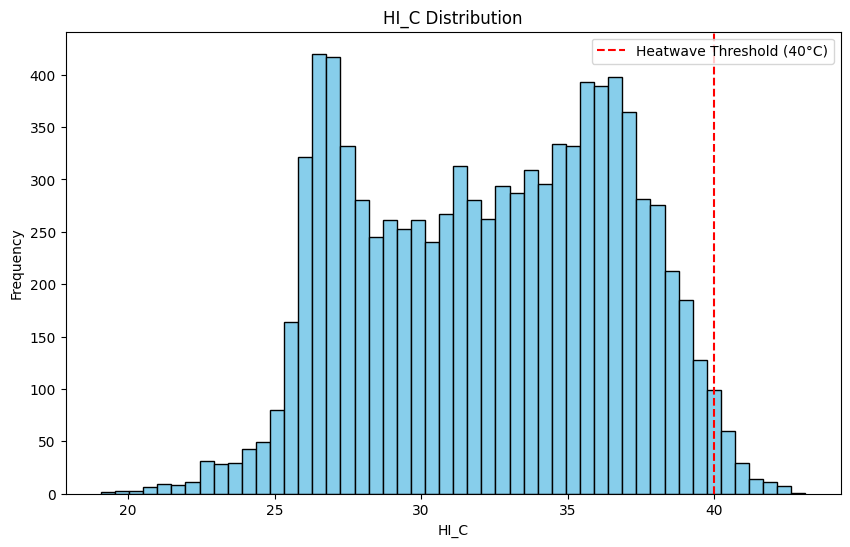

In [14]:
plt.figure(figsize=(10, 6))
plt.hist(df['HI_C'], bins=50, color='skyblue', edgecolor='black')
plt.axvline(40, color='red', linestyle='--', label='Heatwave Threshold (40°C)')
plt.title('HI_C Distribution')
plt.xlabel('HI_C')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [15]:
df.to_csv('/content/drive/MyDrive/Datasets/final_dataset(2).csv', index=False)
df = pd.read_csv('/content/drive/MyDrive/Datasets/final_dataset(2).csv')
df.head(10)

,valid_time,dewpoint_K,temperature_K,latitude,longitude,surface_pressure,tp,solar_radiation,wind_u,wind_v,temperature_C,dewpoint_C,RH,HI_C,HI_C_lag1,temperature_C_lag1,RH_lag1,month,is_heatwave,HI_C_tomorrow
0,1965-03-01,265.765964,293.883238,28.2,74.0,98469.269667,1.837810e-08,910238.583333,0.697201,0.278050,20.733238,-7.384036,16.025946,25.345643,26.118342,19.354791,21.006634,3,0,25.595259
1,1965-03-02,266.825482,293.274280,28.2,74.0,98448.807083,5.348522e-08,927417.000000,1.819510,-1.791662,20.124280,-6.324518,18.153078,25.595259,25.345643,20.733238,16.025946,3,0,24.871519
2,1965-03-03,264.178834,294.204120,28.2,74.0,98241.011333,1.852424e-08,932405.000000,1.048941,2.395773,21.054120,-8.971166,14.119023,24.871519,25.595259,20.124280,18.153078,3,0,24.226448
3,1965-03-04,264.627617,295.502185,28.2,74.0,98265.072042,3.625949e-08,934627.333333,1.739686,1.874097,22.352185,-8.522383,12.560900,24.226448,24.871519,21.054120,14.119023,3,0,25.541846
4,1965-03-05,268.709188,296.404564,28.2,74.0,98321.527917,3.563861e-08,917300.833333,1.584692,2.197393,23.254564,-4.440812,16.715765,25.541846,24.226448,22.352185,12.560900,3,0,26.467154
5,1965-03-06,272.471775,297.379748,28.2,74.0,98026.109000,7.155765e-08,921397.500000,1.980865,3.249845,24.229748,-0.678225,20.828311,26.467154,25.541846,23.254564,16.715765,3,0,25.878141
6,1965-03-07,277.565191,294.228507,28.2,74.0,98044.683625,1.404908e-06,873646.250000,3.165757,2.187687,21.078507,4.415191,35.045829,25.878141,26.467154,24.229748,20.828311,3,0,26.691912
7,1965-03-08,276.678128,294.554765,28.2,74.0,98299.291000,3.601117e-08,925780.500000,1.807971,-0.787512,21.404765,3.528128,33.828111,26.691912,25.878141,21.078507,35.045829,3,0,26.183643
8,1965-03-09,275.181427,295.436877,28.2,74.0,98522.427708,3.614916e-08,859087.916667,-0.370202,-1.970902,22.286877,2.031427,28.116988,26.183643,26.691912,21.404765,33.828111,3,0,26.504960
9,1965-03-10,274.913149,295.398950,28.2,74.0,98741.270875,5.352000e-08,953919.666667,-1.394840,-1.163584,22.248950,1.763149,28.389941,26.504960,26.183643,22.286877,28.116988,3,0,26.378688


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9318 entries, 0 to 9317
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   valid_time          9318 non-null   object 
 1   dewpoint_K          9318 non-null   float64
 2   temperature_K       9318 non-null   float64
 3   latitude            9318 non-null   float64
 4   longitude           9318 non-null   float64
 5   surface_pressure    9318 non-null   float64
 6   tp                  9318 non-null   float64
 7   solar_radiation     9318 non-null   float64
 8   wind_u              9318 non-null   float64
 9   wind_v              9318 non-null   float64
 10  temperature_C       9318 non-null   float64
 11  dewpoint_C          9318 non-null   float64
 12  RH                  9318 non-null   float64
 13  HI_C                9318 non-null   float64
 14  HI_C_lag1           9318 non-null   float64
 15  temperature_C_lag1  9318 non-null   float64
 16  RH_lag

In [17]:
#Finally LSTM Training part begins
import pandas as pd

# Load your dataset
df = pd.read_csv('/content/drive/MyDrive/Datasets/final_dataset(2).csv')

# Check the shape and columns
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

# Check first few rows
df.head()

Shape: (9318, 20)
Columns: ['valid_time', 'dewpoint_K', 'temperature_K', 'latitude', 'longitude', 'surface_pressure', 'tp', 'solar_radiation', 'wind_u', 'wind_v', 'temperature_C', 'dewpoint_C', 'RH', 'HI_C', 'HI_C_lag1', 'temperature_C_lag1', 'RH_lag1', 'month', 'is_heatwave', 'HI_C_tomorrow']


,valid_time,dewpoint_K,temperature_K,latitude,longitude,surface_pressure,tp,solar_radiation,wind_u,wind_v,temperature_C,dewpoint_C,RH,HI_C,HI_C_lag1,temperature_C_lag1,RH_lag1,month,is_heatwave,HI_C_tomorrow
0,1965-03-01,265.765964,293.883238,28.2,74.0,98469.269667,1.837810e-08,910238.583333,0.697201,0.278050,20.733238,-7.384036,16.025946,25.345643,26.118342,19.354791,21.006634,3,0,25.595259
1,1965-03-02,266.825482,293.274280,28.2,74.0,98448.807083,5.348522e-08,927417.000000,1.819510,-1.791662,20.124280,-6.324518,18.153078,25.595259,25.345643,20.733238,16.025946,3,0,24.871519
2,1965-03-03,264.178834,294.204120,28.2,74.0,98241.011333,1.852424e-08,932405.000000,1.048941,2.395773,21.054120,-8.971166,14.119023,24.871519,25.595259,20.124280,18.153078,3,0,24.226448
3,1965-03-04,264.627617,295.502185,28.2,74.0,98265.072042,3.625949e-08,934627.333333,1.739686,1.874097,22.352185,-8.522383,12.560900,24.226448,24.871519,21.054120,14.119023,3,0,25.541846
4,1965-03-05,268.709188,296.404564,28.2,74.0,98321.527917,3.563861e-08,917300.833333,1.584692,2.197393,23.254564,-4.440812,16.715765,25.541846,24.226448,22.352185,12.560900,3,0,26.467154


In [18]:
# ✅ Creating lag features before LSTM input (useful for sequential memory)
def create_lag_features(df, lag_days=3, target_col='HI_C'):
    for lag in range(1, lag_days + 1):
        df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)
    df.dropna(inplace=True)
    return df

# Apply to your existing DataFrame (before scaling and reshaping)
df_lagged = create_lag_features(df.copy(), lag_days=3, target_col='HI_C')
#

In [19]:
#Adding more lag features to boost the recall upto 0.25, and re-training the model yet again, for a final push

lag_days = [1, 2, 3]

for lag in lag_days:
    df[f'temperature_C_lag_{lag}'] = df['temperature_C'].shift(lag)
    df[f'RH_lag_{lag}'] = df['RH'].shift(lag)
    df[f'dewpoint_C_lag_{lag}'] = df['dewpoint_C'].shift(lag)
    df[f'wind_u_lag_{lag}'] = df['wind_u'].shift(lag)
    df[f'wind_v_lag_{lag}'] = df['wind_v'].shift(lag)

In [20]:
df['HI_C_lag_4'] = df['HI_C'].shift(4)
df['HI_C_lag_5'] = df['HI_C'].shift(5)
df['HI_C_lag_6'] = df['HI_C'].shift(6)


In [21]:
df['delta_temp'] = df['temperature_C'] - df['temperature_C'].shift(1)
df['delta_rh'] = df['RH'] - df['RH'].shift(1)
df['delta_dew'] = df['dewpoint_C'] - df['dewpoint_C'].shift(1)
df['delta_HI_C'] = df['HI_C'] - df['HI_C'].shift(1)

In [22]:
df = df.dropna().reset_index(drop=True)

#After this, this above is the new step, the previous approach of just adding features of HI_C starts from here


In [23]:
# Adding explicit features for LSTM, that is needed to handle the class imbalance, so that it becomes more robust to handle Heatwave Days (1)

# Rolling mean and max of past 7 days
df['HI_C_7day_mean'] = df['HI_C'].rolling(window=7).mean()
df['HI_C_7day_max'] = df['HI_C'].rolling(window=7).max()

# Shift forward so current day doesn't "see itself"
df['HI_C_7day_mean'] = df['HI_C_7day_mean'].shift(1)
df['HI_C_7day_max'] = df['HI_C_7day_max'].shift(1)


In [24]:
df['delta_HI_C_1'] = df['HI_C'] - df['HI_C'].shift(1)
df['delta_HI_C_2'] = df['HI_C'].shift(1) - df['HI_C'].shift(2)


In [25]:
# Flag if yesterday was a HW
df['was_HW_yesterday'] = (df['HI_C'].shift(1) >= 40).astype(int)

# Days since last HW day (running counter)
days_since_hw = []
counter = 0
for val in df['HI_C']:
    if val >= 40:
        counter = 0
    else:
        counter += 1
    days_since_hw.append(counter)
df['days_since_last_HW'] = days_since_hw


In [26]:
df = df.dropna().reset_index(drop=True)


In [27]:
# Cell no. 131
#"GPT look from here, bro" ignore the commented out cells from the below as they are of previous models


# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
# from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras import backend as K
# import tensorflow as tf
# import numpy as np
# import pandas as pd
# from sklearn.preprocessing import MinMaxScaler

# # Load dataset
# df = pd.read_csv('/content/drive/MyDrive/Datasets/final_dataset(2).csv')

# # Sort by time if not already sorted
# df = df.sort_values(by='valid_time').reset_index(drop=True)

# # Drop non-numeric or unnecessary columns if needed (like date)
# # df = df.drop(columns=['valid_time'], errors='ignore')  # remove date if exists

# # Define target and features
# target_col = 'HI_C'
# # Define features (excluding target and categorical/non-numeric)
# features = df.drop(['valid_time', 'is_heatwave', 'HI_C_tomorrow'], axis=1).columns.tolist()

# # Scale features
# scaler = MinMaxScaler()
# X_scaled = scaler.fit_transform(df[features])


# # Define the time steps (past days) and forecast steps (future days)
# n_past = 30    # Number of past days
# n_future = 7  # Number of future days to predict
# target_column = 'HI_C'

# # Convert to numpy array
# # X_data is already defined as X_scaled from scaling step

# # target_idx needs to be defined
# target_idx = df.columns.get_loc(target_column)


# X, y = [], []

# for i in range(n_past, len(X_scaled) - n_future + 1): # Use X_scaled here
#     X.append(X_scaled[i - n_past:i, :])  # all features
#     y.append(X_scaled[i:i + n_future, target_idx])  # only HI_C for next n_future days

# X, y = np.array(X), np.array(y)

# print(f"Input shape: {X.shape}")
# print(f"Target shape: {y.shape}")


# # Total samples
# total_samples = X.shape[0]

# # Define split sizes (80% train, 10% val, 10% test)
# train_size = int(total_samples * 0.8)
# val_size = int(total_samples * 0.1)

# # Indices
# X_train = X[:train_size]
# y_train = y[:train_size]

# X_val = X[train_size:train_size + val_size]
# y_val = y[train_size:train_size + val_size]

# X_test = X[train_size + val_size:]
# y_test = y[train_size + val_size:]

# # Print shapes to confirm
# print("Train shape:", X_train.shape, y_train.shape)
# print("Val shape:", X_val.shape, y_val.shape)
# print("Test shape:", X_test.shape, y_test.shape)


# # Define enhanced LSTM model
# model = Sequential()
# model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(BatchNormalization())
# model.add(Dropout(0.3))

# model.add(LSTM(64, return_sequences=True))
# model.add(BatchNormalization())
# model.add(Dropout(0.3))

# model.add(LSTM(32))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(Dense(n_future))  # Output layer for n_future-day regression

# # This is now added after our recall didn't increase to 0.25 after 2 times adding the lag features of HI_C first and then other
# # extended features of RH, lag and model re-training was done twice

# # # Custom weighted MSE loss
# # def weighted_mse(y_true, y_pred):
# #     # Inverse transform y_true to get actual HI_C
# #     hw_weight = 5.0  # Weight multiplier for HW days
# #     weight = tf.where(y_true >= 40.0, hw_weight, 1.0)
# #     return K.mean(weight * K.square(y_true - y_pred), axis=-1)

# #2.) Trying out second one, now redefining it again at 6:40 PM again, as the weigthed_mse value was assumed as 0.65

# # Calculate the true scaled value of 40°C
# scaled_40 = target_scaler.transform([[40]])[0][0]
# print("Scaled threshold for 40°C HI_C:", scaled_40)


# # Custom weighted MSE loss
# def weighted_mse(y_true, y_pred):
#     # Assign higher weight to HW days (HI_C ≥ 40°C)
#     hw_weight = 5.0
#     non_hw_weight = 1.0

#     # Convert scaled y_true to binary labels (scaled back ≈ HI_C ≥ 40 -> scaled threshold)
#     # We'll assume a scaled threshold ~0.65 (just an example; you can calculate actual HI_C scale value)
#     hw_indicator = K.cast(K.greater_equal(y_true, 0.65), K.floatx())

#     weights = hw_indicator * hw_weight + (1 - hw_indicator) * non_hw_weight
#     squared_error = K.square(y_true - y_pred)
#     weighted_loss = K.mean(weights * squared_error)

#     return weighted_loss


# model.compile(optimizer='adam', loss= weighted_mse, metrics=['mae'])
# model.summary()

# 5.) Here our new approach will start from now on, we have refined our problem statement more so in such a way that now our model will learn what a HW is as well

# GPT look from here - Cell 131

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Bidirectional, Dense, Dropout, BatchNormalization, Multiply, Permute, Flatten, Lambda, Activation, RepeatVector
from tensorflow.keras import backend as K
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import numpy as np
import pandas as pd

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/Datasets/final_dataset(2).csv')
df = df.sort_values(by='valid_time').reset_index(drop=True)

# === Step 1: Multi-output preparation ===
target_col = 'HI_C'
features = df.drop(['valid_time', 'is_heatwave', 'HI_C_tomorrow'], axis=1).columns.tolist()

# Scale all features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df[features])

# Scale HI_C separately
target_scaler = MinMaxScaler()
df['HI_C_scaled'] = target_scaler.fit_transform(df[['HI_C']])
scaled_40 = target_scaler.transform([[40]])[0][0]
print("Scaled threshold for 40°C HI_C:", scaled_40)

# Window sizes
n_past = 30
n_future = 7
target_idx = df.columns.get_loc('HI_C')

# === Step 2: Sequence generation for regression & classification ===
X, y_reg, y_class = [], [], []
for i in range(n_past, len(X_scaled) - n_future + 1):
    X.append(X_scaled[i - n_past:i, :])
    y_reg.append(df['HI_C_scaled'].values[i:i+n_future])
    y_class.append(int(np.any(df['HI_C'].values[i:i+n_future] >= 40)))  # Binary: any HW day in next 7

X = np.array(X)
y_reg = np.array(y_reg)
y_class = np.array(y_class)

print(f"Input shape: {X.shape}")
print(f"Regression target shape: {y_reg.shape}")
print(f"Classification target shape: {y_class.shape}")

# === Step 3: Train-val-test split ===
total_samples = X.shape[0]
train_size = int(total_samples * 0.8)
val_size = int(total_samples * 0.1)

X_train = X[:train_size]
y_train_reg = y_reg[:train_size]
y_train_class = y_class[:train_size]

X_val = X[train_size:train_size + val_size]
y_val_reg = y_reg[train_size:train_size + val_size]
y_val_class = y_class[train_size:train_size + val_size]

X_test = X[train_size + val_size:]
y_test_reg = y_reg[train_size + val_size:]
y_test_class = y_class[train_size + val_size:]

print("Train:", X_train.shape, y_train_reg.shape, y_train_class.shape)
print("Val:", X_val.shape, y_val_reg.shape, y_val_class.shape)
print("Test:", X_test.shape, y_test_reg.shape, y_test_class.shape)

# # === Step 4: Model architecture ===
# inp = Input(shape=(n_past, X.shape[2]))

# x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='causal')(inp)
# x = BatchNormalization()(x)
# x = Dropout(0.2)(x)

# x = Bidirectional(LSTM(64, return_sequences=True))(x)
# x = BatchNormalization()(x)
# x = Dropout(0.2)(x)

# # Attention
# attn = Dense(1, activation='tanh')(x)
# attn = Flatten()(attn)
# attn = Activation('softmax')(attn)
# attn = RepeatVector(128)(attn)
# attn = Permute([2, 1])(attn)
# x = Multiply()([x, attn])
# x = Lambda(lambda z: K.sum(z, axis=1))(x)

#6.) Above is old approach for attention, now we have new one to try out here

# === Step 3: Multi-output Model Definition (Upgraded) ===
inp = Input(shape=(n_past, X.shape[2]))

x = Conv1D(filters=128, kernel_size=3, activation='relu', padding='causal')(inp)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

# Attention
attn = Dense(1, activation='tanh')(x)
attn = tf.keras.layers.Flatten()(attn)
attn = tf.keras.layers.Activation('softmax')(attn)
attn = tf.keras.layers.RepeatVector(128)(attn)
attn = tf.keras.layers.Permute([2, 1])(attn)
x = Multiply()([x, attn])
x = tf.keras.layers.Lambda(lambda z: K.sum(z, axis=1))(x)

# Output layers
reg_out = Dense(n_future, name='reg_output')(x)
class_out = Dense(1, activation='sigmoid', name='class_output')(x)
model = Model(inputs=inp, outputs=[reg_out, class_out])

# Custom weighted MSE
def weighted_mse(y_true, y_pred):
    hw_weight = 5.0
    non_hw_weight = 1.0
    weights = tf.where(y_true >= scaled_40, hw_weight, non_hw_weight)
    return K.mean(weights * K.square(y_true - y_pred), axis=-1)

# Compile
model.compile(
    optimizer='adam',
    loss={
        'reg_output': weighted_mse,
        'class_output': 'binary_crossentropy'
    },
    loss_weights={
        'reg_output': 1.0,
        'class_output': 0.5
    },
    metrics={
        'reg_output': ['mae'],
        'class_output': ['accuracy']
    }
)
model.summary()

# 4.) Even our 4th model after trying out logistic classification and smart thresholding also really didn't work out properly, but we'll be sticking out with
# 4th model only as of now as well yet again, but we'll be doing multi-output, where our model will also be learning as to what a HW really is
# so we'll be commenting out this one as well, but we'll be using a better loss function

# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, BatchNormalization, Bidirectional
# from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras import backend as K
# import tensorflow as tf
# import numpy as np
# import pandas as pd
# from sklearn.preprocessing import MinMaxScaler

# # Load dataset
# df = pd.read_csv('/content/drive/MyDrive/Datasets/final_dataset(2).csv')

# # Sort by time if not already sorted
# df = df.sort_values(by='valid_time').reset_index(drop=True)

# # Define target and features
# target_col = 'HI_C'
# features = df.drop(['valid_time', 'is_heatwave', 'HI_C_tomorrow'], axis=1).columns.tolist()

# # Scale features
# scaler = MinMaxScaler()
# X_scaled = scaler.fit_transform(df[features])

# # Define the time steps (past days) and forecast steps (future days)
# n_past = 30    # Number of past days
# n_future = 7   # Number of future days to predict
# target_column = 'HI_C'
# target_idx = df.columns.get_loc(target_column)

# # Calculate the true scaled value of 40°C
# target_scaler = MinMaxScaler()
# HI_C_values = df[['HI_C']]
# target_scaler.fit(HI_C_values)
# scaled_40 = target_scaler.transform([[40]])[0][0]
# print("Scaled threshold for 40°C HI_C:", scaled_40)

# # Prepare sequences
# X, y = [], []
# for i in range(n_past, len(X_scaled) - n_future + 1):
#     X.append(X_scaled[i - n_past:i, :])
#     y.append(X_scaled[i:i + n_future, target_idx])

# X, y = np.array(X), np.array(y)
# print(f"Input shape: {X.shape}")
# print(f"Target shape: {y.shape}")

# # Split into train, val, test
# total_samples = X.shape[0]
# train_size = int(total_samples * 0.8)
# val_size = int(total_samples * 0.1)

# X_train = X[:train_size]
# y_train = y[:train_size]
# X_val = X[train_size:train_size + val_size]
# y_val = y[train_size:train_size + val_size]
# X_test = X[train_size + val_size:]
# y_test = y[train_size + val_size:]

# print("Train shape:", X_train.shape, y_train.shape)
# print("Val shape:", X_val.shape, y_val.shape)
# print("Test shape:", X_test.shape, y_test.shape)

# # From here 4th new model upgrade starts

# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Conv1D, LSTM, Bidirectional, Dense, Dropout, BatchNormalization, Layer, Multiply, Permute, Reshape
# from tensorflow.keras.layers import Attention, Concatenate

# # Input
# inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))

# # Conv1D for local patterns
# x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='causal')(inputs)
# x = BatchNormalization()(x)
# x = Dropout(0.2)(x)

# # Bi-LSTM for temporal learning
# x = Bidirectional(LSTM(64, return_sequences=True))(x)
# x = BatchNormalization()(x)
# x = Dropout(0.2)(x)

# # Attention Layer
# attention = Dense(1, activation='tanh')(x)
# attention = tf.keras.layers.Flatten()(attention)
# attention = tf.keras.layers.Activation('softmax')(attention)
# attention = tf.keras.layers.RepeatVector(128)(attention)  # 128 is Bi-LSTM output size
# attention = tf.keras.layers.Permute([2, 1])(attention)

# x = Multiply()([x, attention])  # Apply attention weights
# x = tf.keras.layers.Lambda(lambda xin: K.sum(xin, axis=1))(x)  # Aggregate

# # Final dense output for regression
# output = Dense(n_future)(x)  # Predict next 7 days of HI_C

# # Build model
# model = Model(inputs=inputs, outputs=output)

# # Weighted MSE loss using correctly scaled threshold
# def weighted_mse(y_true, y_pred):
#     hw_weight = 5.0
#     non_hw_weight = 1.0
#     hw_indicator = K.cast(K.greater_equal(y_true, scaled_40), K.floatx())
#     weights = hw_indicator * hw_weight + (1 - hw_indicator) * non_hw_weight
#     squared_error = K.square(y_true - y_pred)
#     weighted_loss = K.mean(weights * squared_error)
#     return weighted_loss

# # Compile
# model.compile(optimizer='adam', loss=weighted_mse, metrics=['mae'])
# model.summary()

# So above was the code for Conv1D + Bi-LSTM + Attention model, this is our 4th model upgrade, after trying two approaches of Options i.e. Option 1 and Option 2(with heatmap)

# Now this is where the model-training of our new approach starts BiLSTM + Conv1D, our 3-rd Model

# model = Sequential()

# # Conv1D Layer
# model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='causal', input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# # BiLSTM Layer
# model.add(Bidirectional(LSTM(64, return_sequences=True)))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(Bidirectional(LSTM(32)))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# # Output Layer
# model.add(Dense(n_future))


# This was the 2nd best model that we needed, but now we'll be scaling up with Bi-LSTM as the current one i.e. Conv1D learns temporal patterns
# and LSTM learns from past -> future (forward) move, but we might also need to go backwards to cath more HI spikes if they cocured, so we use
#Bi-LSTM + Conv1D, above is the code for Bi-LSTM + Conv1D, and then below is Conv1D + LSTM Hybrid

# # Conv1D + LSTM Hybrid Model
# model = Sequential()

# # Temporal convolution layer
# model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='causal', input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# # LSTM layers for temporal memory
# model.add(LSTM(64, return_sequences=True))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(LSTM(32))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# # Output layer
# model.add(Dense(n_future))  # Predict next 7 days

# this here is 2-Dense Layer LSTM, above is the code here for now we'll be using CONV1D + LSTM Hybrid Model rn

# # Define model
# model = Sequential()
# model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(BatchNormalization())
# model.add(Dropout(0.3))

# model.add(LSTM(64, return_sequences=True))
# model.add(BatchNormalization())
# model.add(Dropout(0.3))

# model.add(LSTM(32))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(Dense(n_future))  # Output layer

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Scaled threshold for 40°C HI_C: 0.8705509271903704
Input shape: (9282, 30, 17)
Regression target shape: (9282, 7)
Classification target shape: (9282,)
Train: (7425, 30, 17) (7425, 7) (7425,)
Val: (928, 30, 17) (928, 7) (928,)
Test: (929, 30, 17) (929, 7) (929,)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 30, 17)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 30, 128)   │      6,656 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 30, 128)   │        512 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 30, 128)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 30, 256)   │    263,168 │ dropout[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 256)   │      1,024 │ bidirectional[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 30, 256)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 30, 128)   │    164,352 │ dropout_1[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 128)   │        512 │ bidirectional_1[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 30, 128)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 30, 1)     │        129 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 30)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 30)        │          0 │ flatten[0][0]     │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 128, 30)   │          0 │ activation[0][0]  │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute (Permute)   │ (None, 30, 128)   │          0 │ repeat_vector[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 30, 128)   │          0 │ dropout_2[0][0],  │
│                     │                   │            │ permute[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 128)       │          0 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reg_output (Dense)  │ (None, 7)         │        903 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ class_output        │ (None, 1)         │        129 │ lambda[0][0]      │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 437,385 (1.67 MB)

 Trainable params: 436,361 (1.66 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [28]:
# Cell no. 132, "GPT bro, from here start looking at things even comments as well, again some of them may include previous model's so ignore them"

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os
import numpy as np
import tensorflow as tf

# Set seed for reproducibility
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Early stopping — FIX: added mode='min'
early_stop = EarlyStopping(
    monitor='val_reg_output_mae',   # Regression MAE
    mode='min',                     # ✅ Tell Keras to minimize MAE
    patience=30,
    restore_best_weights=True,
    min_delta=0.0005
)

# Reduce LR on plateau — also added mode for clarity
reduce_lr = ReduceLROnPlateau(
    monitor='val_reg_output_mae',
    mode='min',                    # ✅ MAE should go down
    factor=0.5,
    patience=10,
    min_lr=1e-6,
    verbose=1
)

# Train the model (multi-task)
history = model.fit(
    X_train,
    {'reg_output': y_train_reg, 'class_output': y_train_class},
    validation_data=(X_val, {'reg_output': y_val_reg, 'class_output': y_val_class}),
    epochs=150,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


Epoch 1/150
233/233 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - class_output_accuracy: 0.8514 - class_output_loss: 0.3232 - loss: 0.3768 - reg_output_loss: 0.2152 - reg_output_mae: 0.3080 - val_class_output_accuracy: 0.9450 - val_class_output_loss: 0.2090 - val_loss: 0.1355 - val_reg_output_loss: 0.0310 - val_reg_output_mae: 0.1249 - learning_rate: 0.0010
Epoch 2/150
233/233 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - class_output_accuracy: 0.9408 - class_output_loss: 0.1626 - loss: 0.1159 - reg_output_loss: 0.0346 - reg_output_mae: 0.1409 - val_class_output_accuracy: 0.9407 - val_class_output_loss: 0.1907 - val_loss: 0.1156 - val_reg_output_loss: 0.0203 - val_reg_output_mae: 0.1012 - learning_rate: 0.0010
Epoch 3/150
233/233 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - class_output_accuracy: 0.9403 - class_output_loss: 0.1513 - loss: 0.1009 - reg_output_loss: 0.0252 - reg_output_mae: 0.1206 - val_class_output_accuracy: 0.9364 - val_class_output_loss: 0.1966 - val_loss: 0.1191 - val_reg_output_loss: 0.0208 - 

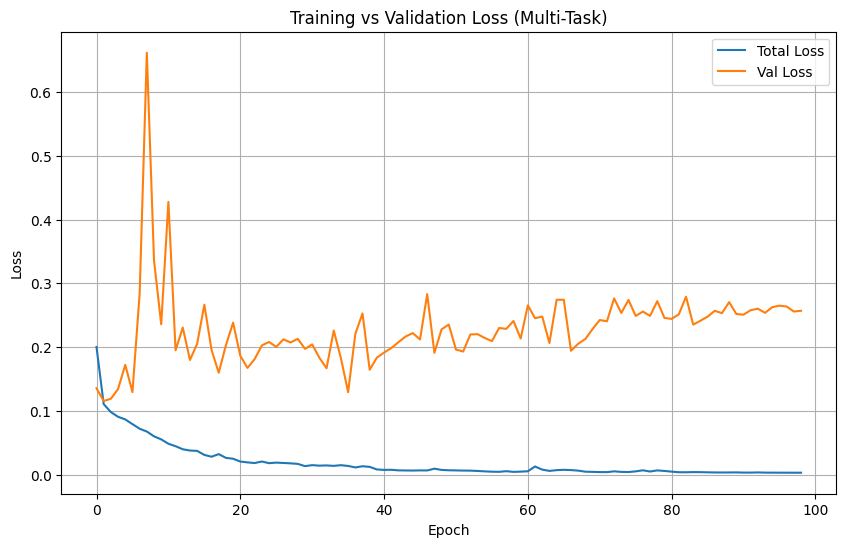

In [29]:
# Cell no. 133, "If any comment # like this will come after this, please look at them seriously"

# import matplotlib.pyplot as plt

# plt.plot(history.history['loss'], label='Train Loss')
# plt.plot(history.history['val_loss'], label='Val Loss')
# plt.xlabel('Epoch')
# plt.ylabel('MSE Loss')
# plt.title('Training vs Validation Loss')
# plt.legend()
# plt.grid(True)
# plt.show()


#Above was our previous approach, we now need to work with new Multi-output logic

# Cell 133 - Training and Validation Loss Plot

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Total Loss')
plt.plot(history.history['val_loss'], label='Val Loss')

# Optional: plot individual component losses
if 'regression_output_loss' in history.history:
    plt.plot(history.history['regression_output_loss'], label='Reg Loss')
    plt.plot(history.history['val_regression_output_loss'], label='Val Reg Loss')

if 'classification_output_loss' in history.history:
    plt.plot(history.history['classification_output_loss'], label='Cls Loss')
    plt.plot(history.history['val_classification_output_loss'], label='Val Cls Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss (Multi-Task)')
plt.legend()
plt.grid(True)
plt.show()



In [30]:
# Cell no. 134

# Predict on validation set
y_val_pred = model.predict(X_val)

# Unpack regression predictions
y_val_pred_reg = y_val_pred[0]  # regression output
y_val_reg_true = y_val_reg      # ground truth

# Inverse transform predicted and actual HI_C values
y_val_pred_rescaled = target_scaler.inverse_transform(y_val_pred_reg)
y_val_true_rescaled = target_scaler.inverse_transform(y_val_reg_true)

# Flatten for metric calculation
y_val_pred_flat = y_val_pred_rescaled.flatten()
y_val_true_flat = y_val_true_rescaled.flatten()

# Calculate regression metrics
from sklearn.metrics import mean_absolute_error, r2_score

mae_val = mean_absolute_error(y_val_true_flat, y_val_pred_flat)
r2_val = r2_score(y_val_true_flat, y_val_pred_flat)

print(f"MAE on Validation Set: {mae_val:.4f}")
print(f"R² on Validation Set: {r2_val:.4f}")


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
MAE on Validation Set: 1.5746
R² on Validation Set: 0.7904


In [31]:
# # Cell no. 135
# # from here you need to scan till 142 ChatGPT bro

# import numpy as np
# from sklearn.metrics import classification_report
# from sklearn.preprocessing import MinMaxScaler # Import MinMaxScaler

# # Assuming y_val and y_val_pred are available from previous steps
# # Assuming scaler and features are available from previous steps

# # Assuming X and y are available from sequence creation (cell hnSbZ6eXV97i or AyYZ_V76F4XX)

# # Load dataset
# df = pd.read_csv('/content/drive/MyDrive/Datasets/final_dataset(2).csv')
# df = df.sort_values(by='valid_time').reset_index(drop=True)

# # === Step 1: Multi-output preparation ===
# target_col = 'HI_C'
# features = df.drop(['valid_time', 'is_heatwave', 'HI_C_tomorrow'], axis=1).columns.tolist()

# # Scale all features
# scaler = MinMaxScaler()
# X_scaled = scaler.fit_transform(df[features])

# # Scale target HI_C separately
# target_scaler = MinMaxScaler()
# df['HI_C_scaled'] = target_scaler.fit_transform(df[['HI_C']])
# scaled_40 = target_scaler.transform([[40]])[0][0]

# # Define windows
# n_past = 30
# n_future = 7
# target_idx = df.columns.get_loc('HI_C')

# # === Step 2: Multi-task labels (regression + classification) ===
# X, y_reg, y_class = [], [], []
# for i in range(n_past, len(X_scaled) - n_future + 1):
#     X.append(X_scaled[i - n_past:i, :])

#     # Regression label: next 7 HI_C values (scaled)
#     y_reg.append(df['HI_C_scaled'].values[i:i+n_future])

#     # Classification label: was there ANY heatwave day in next 7?
#     y_class.append(int(np.any(df['HI_C'].values[i:i+n_future] >= 40)))

# X, y_reg, y_class = np.array(X), np.array(y_reg), np.array(y_class)

# # Total samples
# total_samples = X.shape[0]

# # Define split sizes (80% train, 10% val, 10% test)
# train_size = int(total_samples * 0.8)
# val_size = int(total_samples * 0.1)

# # Indices
# X_train = X[:train_size]
# y_train_reg = y_reg[:train_size]
# y_train_class = y_class[:train_size]

# X_val = X[train_size:train_size + val_size]
# y_val_reg = y_reg[train_size:train_size + val_size]
# y_val_class = y_class[train_size:train_size + val_size]

# X_test = X[train_size + val_size:]
# y_test_reg = y_reg[train_size + val_size:]
# y_test_class = y_class[train_size + val_size:]


# # Predict on validation set
# y_val_pred = model.predict(X_val)
# y_val = y_val_reg # Use the regression target for evaluation metrics

# # We need to inverse transform y_val and y_val_pred to the original scale
# # We need to create dummy arrays with the same number of features as the original data (17)
# dummy_for_val = np.zeros((y_val.shape[0], scaler.n_features_in_))
# dummy_for_val_pred = np.zeros((y_val_pred[0].shape[0], scaler.n_features_in_))

# # Find the index of 'HI_C' in the features list
# target_feature_index_in_features = features.index('HI_C')

# y_val_rescaled_list = []
# y_val_pred_rescaled_list = []

# # Assuming y_val and y_val_pred have shape (num_samples, n_future)
# for i in range(n_future):
#     # Create dummy arrays of shape (num_samples, num_features)
#     dummy_val_step = np.zeros((y_val.shape[0], scaler.n_features_in_))
#     dummy_val_pred_step = np.zeros((y_val_pred[0].shape[0], scaler.n_features_in_))

#     # Place the i-th actual/predicted HI_C value into the target feature column
#     dummy_val_step[:, target_feature_index_in_features] = y_val[:, i]
#     dummy_val_pred_step[:, target_feature_index_in_features] = y_val_pred[0][:, i]

#     # Inverse transform and store
#     y_val_rescaled_list.append(scaler.inverse_transform(dummy_val_step)[:, target_feature_index_in_features])
#     y_val_pred_rescaled_list.append(scaler.inverse_transform(dummy_val_pred_step)[:, target_feature_index_in_features])

# # Stack the results to get arrays of shape (num_samples, n_future)
# y_val_rescaled = np.stack(y_val_rescaled_list, axis=1)
# y_val_pred_rescaled = np.stack(y_val_pred_rescaled_list, axis=1)


# # Convert HI forecast to binary HW labels (threshold ≥ 40°C)
# y_val_bin_true = (y_val_rescaled >= 40).astype(int).flatten()
# y_val_bin_pred = (y_val_pred_rescaled >= 40).astype(int).flatten()

# # Compute recall for HW days
# print(classification_report(
#     y_val_bin_true,
#     y_val_bin_pred,
#     target_names=['Non-HW', 'HW'],
#     labels=[0, 1] # Explicitly specify labels
# )) # this was old cell


#  Cell 135 - Classification Report from Multi-Task Outputs

import numpy as np
from sklearn.metrics import classification_report

# Predict on validation set again (if needed)
y_val_pred = model.predict(X_val)
y_val_pred_reg = y_val_pred[0]  # Regression output

# Rescale regression predictions and ground truth
y_val_pred_rescaled = target_scaler.inverse_transform(y_val_pred_reg)
y_val_true_rescaled = target_scaler.inverse_transform(y_val_reg)

# Convert to binary HW/non-HW labels using threshold (40°C)
y_val_pred_bin = (y_val_pred_rescaled >= 40).astype(int).flatten()
y_val_true_bin = (y_val_true_rescaled >= 40).astype(int).flatten()

# Generate classification report for heatwave detection
print(classification_report(
    y_val_true_bin,
    y_val_pred_bin,
    target_names=["Non-HW", "HW"],
    labels=[0, 1]
))

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
              precision    recall  f1-score   support

      Non-HW       0.98      1.00      0.99      6384
          HW       0.33      0.13      0.19       112

    accuracy                           0.98      6496
   macro avg       0.66      0.56      0.59      6496
weighted avg       0.97      0.98      0.98      6496



In [32]:
# # Cell no. 136

# # 2. Use y_pred_rescaled to train a classifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import classification_report
# import numpy as np
# from sklearn.preprocessing import MinMaxScaler # Import MinMaxScaler

# # Assuming y_val and y_val_pred are available from previous steps
# # Assuming scaler and features are available from previous steps

# # Assuming X and y are available from sequence creation (cell hnSbZ6eXV97i or AyYZ_V6281)

# # Load dataset
# df = pd.read_csv('/content/drive/MyDrive/Datasets/final_dataset(2).csv')
# df = df.sort_values(by='valid_time').reset_index(drop=True)

# # === Step 1: Multi-output preparation ===
# target_col = 'HI_C'
# features = df.drop(['valid_time', 'is_heatwave', 'HI_C_tomorrow'], axis=1).columns.tolist()

# # Scale all features
# scaler = MinMaxScaler()
# X_scaled = scaler.fit_transform(df[features])

# # Scale target HI_C separately
# target_scaler = MinMaxScaler()
# df['HI_C_scaled'] = target_scaler.fit_transform(df[['HI_C']])
# scaled_40 = target_scaler.transform([[40]])[0][0]

# # Define windows
# n_past = 30
# n_future = 7
# target_idx = df.columns.get_loc('HI_C')

# # === Step 2: Multi-task labels (regression + classification) ===
# X, y_reg, y_class = [], [], []
# for i in range(n_past, len(X_scaled) - n_future + 1):
#     X.append(X_scaled[i - n_past:i, :])

#     # Regression label: next 7 HI_C values (scaled)
#     y_reg.append(df['HI_C_scaled'].values[i:i+n_future])

#     # Classification label: was there ANY heatwave day in next 7?
#     y_class.append(int(np.any(df['HI_C'].values[i:i+n_future] >= 40)))

# X, y_reg, y_class = np.array(X), np.array(y_reg), np.array(y_class)

# # Total samples
# total_samples = X.shape[0]

# # Define split sizes (80% train, 10% val, 10% test)
# train_size = int(total_samples * 0.8)
# val_size = int(total_samples * 0.1)

# # Indices
# X_train = X[:train_size]
# y_train_reg = y_reg[:train_size]
# y_train_class = y_class[:train_size]

# X_val = X[train_size:train_size + val_size]
# y_val_reg = y_reg[train_size:train_size + val_size]
# y_val_class = y_class[train_size:train_size + val_size]

# X_test = X[train_size + val_size:]
# y_test_reg = y_reg[train_size + val_size:]
# y_test_class = y_class[train_size + val_size:]


# # Predict on validation set
# y_val_pred = model.predict(X_val)
# y_val = y_val_reg # Use the regression target for evaluation metrics

# # We need to inverse transform y_val and y_val_pred to the original scale
# # We need to create dummy arrays with the same number of features as the original data (17)
# dummy_for_val = np.zeros((y_val.shape[0], scaler.n_features_in_))
# dummy_for_val_pred = np.zeros((y_val_pred[0].shape[0], scaler.n_features_in_))

# # Find the index of 'HI_C' in the features list
# target_feature_index_in_features = features.index('HI_C')

# y_val_rescaled_list = []
# y_val_pred_rescaled_list = []

# # Assuming y_val and y_val_pred have shape (num_samples, n_future)
# for i in range(n_future):
#     # Create dummy arrays of shape (num_samples, num_features)
#     dummy_val_step = np.zeros((y_val.shape[0], scaler.n_features_in_))
#     dummy_val_pred_step = np.zeros((y_val_pred[0].shape[0], scaler.n_features_in_))

#     # Place the i-th actual/predicted HI_C value into the target feature column
#     dummy_val_step[:, target_feature_index_in_features] = y_val[:, i]
#     dummy_val_pred_step[:, target_feature_index_in_features] = y_val_pred[0][:, i]

#     # Inverse transform and store
#     y_val_rescaled_list.append(scaler.inverse_transform(dummy_val_step)[:, target_feature_index_in_features])
#     y_val_pred_rescaled_list.append(scaler.inverse_transform(dummy_val_pred_step)[:, target_feature_index_in_features])

# # Stack the results to get arrays of shape (num_samples, n_future)
# y_val_rescaled = np.stack(y_val_rescaled_list, axis=1)
# y_val_pred_rescaled = np.stack(y_val_pred_rescaled_list, axis=1)


# # Predict on test set
# y_test_pred = model.predict(X_test)

# # We need to inverse transform y_test and y_test_pred to the original scale
# dummy_for_test = np.zeros((y_test_reg.shape[0], scaler.n_features_in_))
# dummy_for_test_pred = np.zeros((y_test_pred[0].shape[0], scaler.n_features_in_))

# y_test_rescaled_list = []
# y_test_pred_rescaled_list = []

# for i in range(n_future):
#     dummy_test_step = np.zeros((y_test_reg.shape[0], scaler.n_features_in_))
#     dummy_test_pred_step = np.zeros((y_test_pred[0].shape[0], scaler.n_features_in_))

#     dummy_test_step[:, target_feature_index_in_features] = y_test_reg[:, i]
#     dummy_test_pred_step[:, target_feature_index_in_features] = y_test_pred[0][:, i]

#     y_test_rescaled_list.append(scaler.inverse_transform(dummy_test_step)[:, target_feature_index_in_features])
#     y_test_pred_rescaled_list.append(scaler.inverse_transform(dummy_test_pred_step)[:, target_feature_index_in_features])

# y_test_rescaled = np.stack(y_test_rescaled_list, axis=1)
# y_test_pred_rescaled = np.stack(y_test_pred_rescaled_list, axis=1)


# X_cls = y_test_pred_rescaled  # shape (samples, 7)
# # Fix: Transform the target into a 1D binary array
# y_cls = (np.max(y_test_rescaled, axis=1) >= 40).astype(int)  # binary labels (1D)

# clf = LogisticRegression(max_iter=1000)
# clf.fit(X_cls, y_cls)

# y_cls_pred = clf.predict(X_cls)
# print(classification_report(y_cls, y_cls_pred, target_names=['Non-HW', 'HW']))


## Our new present code cell:

# GPT Cell 136 – Secondary Logistic Classifier on Predicted HI_C to improve HW recall

# Cell 136 – Logistic Regression on Rescaled HI Forecasts

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import numpy as np

# Predict on test set (MUST run this first to avoid NameError)
y_test_pred = model.predict(X_test)  # [reg_output, class_output]

# Rescale predicted and true values (only for regression output)
# Create dummy arrays for inverse_transform
dummy_for_test = np.zeros((y_test_reg.shape[0], scaler.n_features_in_))
dummy_for_test_pred = np.zeros((y_test_pred[0].shape[0], scaler.n_features_in_))

target_feature_index = features.index('HI_C')

# Step through each forecast day and inverse transform
y_test_rescaled_list = []
y_test_pred_rescaled_list = []

for i in range(n_future):
    dummy_true = np.zeros((y_test_reg.shape[0], scaler.n_features_in_))
    dummy_pred = np.zeros((y_test_pred[0].shape[0], scaler.n_features_in_))

    dummy_true[:, target_feature_index] = y_test_reg[:, i]
    dummy_pred[:, target_feature_index] = y_test_pred[0][:, i]

    y_test_rescaled_list.append(scaler.inverse_transform(dummy_true)[:, target_feature_index])
    y_test_pred_rescaled_list.append(scaler.inverse_transform(dummy_pred)[:, target_feature_index])

# Final stacked arrays: shape (samples, 7)
y_test_rescaled = np.stack(y_test_rescaled_list, axis=1)
y_test_pred_rescaled = np.stack(y_test_pred_rescaled_list, axis=1)

# Convert into binary HW labels: 1 if any of the 7 values ≥ 40°C
X_cls = y_test_pred_rescaled
y_cls = (np.max(y_test_rescaled, axis=1) >= 40).astype(int)

# Train classifier on regression predictions
clf = LogisticRegression(max_iter=1000)
clf.fit(X_cls, y_cls)

# Predict HW labels
y_cls_pred = clf.predict(X_cls)

# Show classification performance
print(classification_report(y_cls, y_cls_pred, target_names=['Non-HW', 'HW']))



30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
              precision    recall  f1-score   support

      Non-HW       0.93      0.96      0.94       803
          HW       0.66      0.56      0.60       126

    accuracy                           0.90       929
   macro avg       0.80      0.76      0.77       929
weighted avg       0.90      0.90      0.90       929



30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Test Loss: 0.6170, Test MAE (HI_C): 0.8332


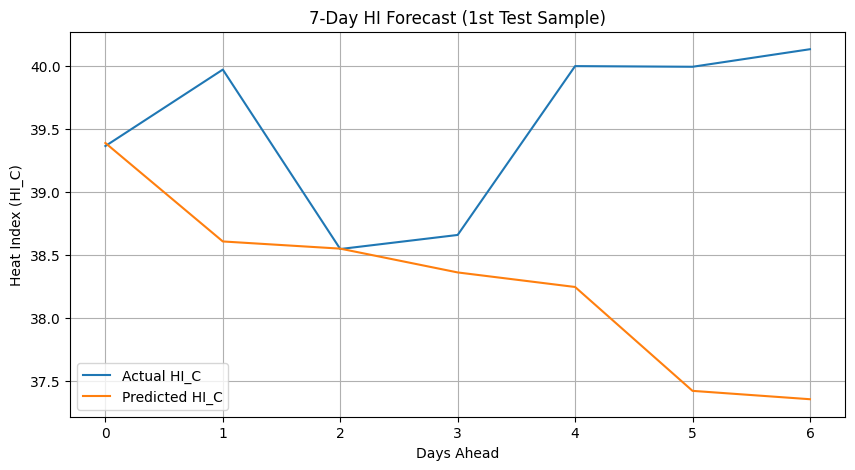

In [33]:
# # Cell no. 137

# import matplotlib.pyplot as plt
# import numpy as np
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import classification_report
# from sklearn.preprocessing import MinMaxScaler
# # Assuming X_test, y_test, X_scaled, features, target_feature_index_in_features, and scaler are available from previous steps

# # Load dataset
# df = pd.read_csv('/content/drive/MyDrive/Datasets/final_dataset(2).csv')
# df = df.sort_values(by='valid_time').reset_index(drop=True)

# # === Step 1: Multi-output preparation ===
# target_col = 'HI_C'
# features = df.drop(['valid_time', 'is_heatwave', 'HI_C_tomorrow'], axis=1).columns.tolist()

# # Scale all features
# scaler = MinMaxScaler()
# X_scaled = scaler.fit_transform(df[features])

# # Scale target HI_C separately
# target_scaler = MinMaxScaler()
# df['HI_C_scaled'] = target_scaler.fit_transform(df[['HI_C']])
# scaled_40 = target_scaler.transform([[40]])[0][0]

# # Define windows
# n_past = 30
# n_future = 7
# target_idx = df.columns.get_loc('HI_C')

# # === Step 2: Multi-task labels (regression + classification) ===
# X, y_reg, y_class = [], [], []
# for i in range(n_past, len(X_scaled) - n_future + 1):
#     X.append(X_scaled[i - n_past:i, :])

#     # Regression label: next 7 HI_C values (scaled)
#     y_reg.append(df['HI_C_scaled'].values[i:i+n_future])

#     # Classification label: was there ANY heatwave day in next 7?
#     y_class.append(int(np.any(df['HI_C'].values[i:i+n_future] >= 40)))

# X, y_reg, y_class = np.array(X), np.array(y_reg), np.array(y_class)

# # Total samples
# total_samples = X.shape[0]

# # Define split sizes (80% train, 10% val, 10% test)
# train_size = int(total_samples * 0.8)
# val_size = int(total_samples * 0.1)

# # Indices
# X_train = X[:train_size]
# y_train_reg = y_reg[:train_size]
# y_train_class = y_class[:train_size]

# X_val = X[train_size:train_size + val_size]
# y_val_reg = y_reg[train_size:train_size + val_size]
# y_val_class = y_class[train_size:train_size + val_size]

# X_test = X[train_size + val_size:]
# y_test_reg = y_reg[train_size + val_size:]
# y_test_class = y_class[train_size + val_size:]

# # Evaluate on test data
# # Access the regression output specifically for evaluation
# test_results = model.evaluate(X_test, {'reg_output': y_test_reg, 'class_output': y_test_class}, verbose=0)
# test_loss = test_results[0]
# test_mae = test_results[3] # MAE is the 4th element in the results list

# print(f"\nTest Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")

# # Predict
# y_pred = model.predict(X_test)

# # Access the regression output for plotting and inverse scaling
# y_pred_reg = y_pred[0]

# # Inverse scaling for both predicted and actual values
# # We need to create dummy arrays with the same number of features as the original data (17)

# # Find the index of 'HI_C' in the features list
# target_feature_index_in_features = features.index('HI_C')

# y_pred_rescaled_list = []
# y_test_rescaled_list = []

# for i in range(n_future):
#     # Create dummy arrays of shape (num_samples, num_features)
#     dummy_pred_step = np.zeros((y_pred_reg.shape[0], scaler.n_features_in_)) # Use y_pred_reg here
#     dummy_test_step = np.zeros((y_test_reg.shape[0], scaler.n_features_in_)) # Use y_test_reg here

#     # Place the i-th predicted/actual HI_C value into the target feature column
#     dummy_pred_step[:, target_feature_index_in_features] = y_pred_reg[:, i] # Use y_pred_reg here
#     dummy_test_step[:, target_feature_index_in_features] = y_test_reg[:, i] # Use y_test_reg here

#     # Inverse transform and store
#     y_pred_rescaled_list.append(scaler.inverse_transform(dummy_pred_step)[:, target_feature_index_in_features])
#     y_test_rescaled_list.append(scaler.inverse_transform(dummy_test_step)[:, target_feature_index_in_features])

# # Stack the results to get arrays of shape (num_samples, n_future)
# y_pred_rescaled = np.stack(y_pred_rescaled_list, axis=1)
# y_test_rescaled = np.stack(y_test_rescaled_list, axis=1)


# # Plot: Actual vs Predicted for 1st test sample
# plt.figure(figsize=(10, 5))
# plt.plot(range(n_future), y_test_rescaled[0], label='Actual')
# plt.plot(range(n_future), y_pred_rescaled[0], label='Predicted')
# plt.title(f"{n_future}-Day HI Forecast (1 Sample)")
# plt.xlabel("Days Ahead")
# plt.ylabel("HI_C")
# plt.legend()
# plt.grid(True)
# plt.show()

## New code cell present here:

# Cell 137 – Final Evaluation and Regression Plot

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# === Access test predictions ===
y_test_pred = model.predict(X_test)
y_test_pred_reg = y_test_pred[0]  # Regression output
y_test_pred_cls = y_test_pred[1]  # Classification output

# Evaluate model using same outputs structure as used in model.compile()
test_results = model.evaluate(X_test, [y_test_reg, y_test_class], verbose=0)
test_loss = test_results[0]
test_mae = test_results[3]  # MAE for regression output

print(f"\nTest Loss: {test_loss:.4f}, Test MAE (HI_C): {test_mae:.4f}")

# === Inverse scaling for visualization ===
y_pred_rescaled_list = []
y_test_rescaled_list = []

for i in range(n_future):
    dummy_pred = np.zeros((y_test_pred_reg.shape[0], scaler.n_features_in_))
    dummy_true = np.zeros((y_test_reg.shape[0], scaler.n_features_in_))

    dummy_pred[:, target_feature_index] = y_test_pred_reg[:, i]
    dummy_true[:, target_feature_index] = y_test_reg[:, i]

    y_pred_rescaled_list.append(scaler.inverse_transform(dummy_pred)[:, target_feature_index])
    y_test_rescaled_list.append(scaler.inverse_transform(dummy_true)[:, target_feature_index])

y_pred_rescaled = np.stack(y_pred_rescaled_list, axis=1)
y_test_rescaled = np.stack(y_test_rescaled_list, axis=1)

# === Plotting actual vs predicted for 1 sample ===
plt.figure(figsize=(10, 5))
plt.plot(range(n_future), y_test_rescaled[0], label='Actual HI_C')
plt.plot(range(n_future), y_pred_rescaled[0], label='Predicted HI_C')
plt.title(f"{n_future}-Day HI Forecast (1st Test Sample)")
plt.xlabel("Days Ahead")
plt.ylabel("Heat Index (HI_C)")
plt.legend()
plt.grid(True)
plt.show()


In [34]:
# Cell 138 – Compute Heatwave Recall from Regression Output

import numpy as np
from sklearn.metrics import recall_score

# Convert predicted and actual HI_C values to binary: 1 if ≥ 40°C else 0
actual_hw = (y_test_rescaled >= 40).astype(int).flatten()
pred_hw = (y_pred_rescaled >= 40).astype(int).flatten()

# Recall: % of actual HW days correctly predicted
recall = recall_score(actual_hw, pred_hw)
print(f"Heatwave Recall (via thresholded HI_C): {recall:.4f}")


Heatwave Recall (via thresholded HI_C): 0.0286


In [35]:
# # Cell 139 – Evaluate Multi-task HW Classification Head (Clean Version)
## Fixed by colab's gemini
# # Predict both outputs on test set
# y_pred_reg, y_pred_cls = model.predict(X_test)

# # Inverse scale regression output (HI_C)
# y_pred_reg_unscaled_list = []
# y_test_reg_unscaled_list = []

# # Find the index of 'HI_C' in the features list
# target_feature_index_in_features = features.index('HI_C')

# for i in range(n_future):
#     dummy_pred = np.zeros((y_pred_reg.shape[0], scaler.n_features_in_))
#     dummy_test = np.zeros((y_test_reg.shape[0], scaler.n_features_in_))

#     dummy_pred[:, target_feature_index_in_features] = y_pred_reg[:, i]
#     dummy_test[:, target_feature_index_in_features] = y_test_reg[:, i]

#     y_pred_reg_unscaled_list.append(scaler.inverse_transform(dummy_pred)[:, target_feature_index_in_features])
#     y_test_reg_unscaled_list.append(scaler.inverse_transform(dummy_test)[:, target_feature_index_in_features])

# y_pred_reg_unscaled = np.stack(y_pred_reg_unscaled_list, axis=1)
# y_test_reg_unscaled = np.stack(y_test_reg_unscaled_list, axis=1)

# # Threshold classifier head output
# y_pred_cls_binary = (y_pred_cls >= 0.5).astype(int)

# # Evaluate binary classification performance
# from sklearn.metrics import classification_report

# print("Classification Report (Multi-Task Model - HW Detection):")
# print(classification_report(y_test_class.flatten(), y_pred_cls_binary.flatten(), target_names=['Non-HW', 'HW']))

## Testing GPT for code cell 139
# ✅ Cell 139 – Evaluate Multi-task HW Classification Head (Clean & Final)

# Predict both outputs on test set
y_pred_reg, y_pred_cls = model.predict(X_test)

# Recompute target feature index (safe fallback)
target_feature_index_in_features = features.index('HI_C')

# Inverse scale regression output (HI_C)
y_pred_reg_unscaled_list = []
y_test_reg_unscaled_list = []

for i in range(n_future):
    dummy_pred = np.zeros((y_pred_reg.shape[0], scaler.n_features_in_))
    dummy_test = np.zeros((y_test_reg.shape[0], scaler.n_features_in_))

    dummy_pred[:, target_feature_index_in_features] = y_pred_reg[:, i]
    dummy_test[:, target_feature_index_in_features] = y_test_reg[:, i]

    y_pred_reg_unscaled_list.append(scaler.inverse_transform(dummy_pred)[:, target_feature_index_in_features])
    y_test_reg_unscaled_list.append(scaler.inverse_transform(dummy_test)[:, target_feature_index_in_features])

y_pred_reg_unscaled = np.stack(y_pred_reg_unscaled_list, axis=1)
y_test_reg_unscaled = np.stack(y_test_reg_unscaled_list, axis=1)

# Threshold classifier head output
y_pred_cls_binary = (y_pred_cls >= 0.5).astype(int)

# Evaluate classification performance
from sklearn.metrics import classification_report

print("Classification Report (Multi-Task Model - HW Detection):")
print(classification_report(
    y_test_class.flatten(),
    y_pred_cls_binary.flatten(),
    target_names=['Non-HW', 'HW']
))


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Classification Report (Multi-Task Model - HW Detection):
              precision    recall  f1-score   support

      Non-HW       0.88      0.94      0.91       803
          HW       0.29      0.16      0.21       126

    accuracy                           0.83       929
   macro avg       0.58      0.55      0.56       929
weighted avg       0.80      0.83      0.81       929



In [36]:
# Cell 140 – Adjusted Recall Calculation

from sklearn.metrics import recall_score
import numpy as np

# Apply a slightly lower threshold (e.g., 39.5°C) to increase sensitivity
threshold = 39.5
pred_hw_adj = (y_pred_reg_unscaled >= threshold).astype(int).flatten()
actual_hw_flat = (y_test_reg_unscaled >= 40).astype(int).flatten()

# Calculate recall
recall_adj = recall_score(actual_hw_flat, pred_hw_adj)
print(f"Adjusted Heatwave Recall (Threshold = {threshold}°C): {recall_adj:.4f}")


Adjusted Heatwave Recall (Threshold = 39.5°C): 0.0786


Classification Report for HW Detection via RF:
              precision    recall  f1-score   support

      Non-HW       0.96      0.96      0.96      1245
          HW       0.10      0.11      0.10        56

    accuracy                           0.92      1301
   macro avg       0.53      0.53      0.53      1301
weighted avg       0.92      0.92      0.92      1301



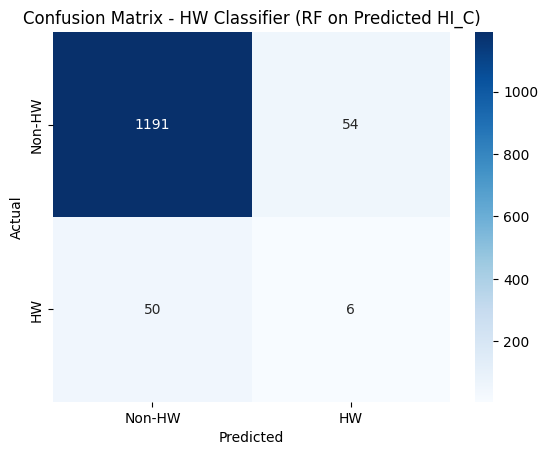

In [37]:
# # Cell no. 141

# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import classification_report, confusion_matrix
# from sklearn.model_selection import train_test_split
# import numpy as np
# from sklearn.preprocessing import MinMaxScaler # Import MinMaxScaler

# # Assuming X_test, y_test, X_scaled, features, target_feature_index_in_features, and scaler are available from previous steps

# # Load dataset
# df = pd.read_csv('/content/drive/MyDrive/Datasets/final_dataset(2).csv')
# df = df.sort_values(by='valid_time').reset_index(drop=True)

# # === Step 1: Multi-output preparation ===
# target_col = 'HI_C'
# features = df.drop(['valid_time', 'is_heatwave', 'HI_C_tomorrow'], axis=1).columns.tolist()

# # Scale all features
# scaler = MinMaxScaler()
# X_scaled = scaler.fit_transform(df[features])

# # Scale target HI_C separately
# target_scaler = MinMaxScaler()
# df['HI_C_scaled'] = target_scaler.fit_transform(df[['HI_C']])
# scaled_40 = target_scaler.transform([[40]])[0][0]

# # Define windows
# n_past = 30
# n_future = 7
# target_idx = df.columns.get_loc('HI_C')

# # === Step 2: Multi-task labels (regression + classification) ===
# X, y_reg, y_class = [], [], []
# for i in range(n_past, len(X_scaled) - n_future + 1):
#     X.append(X_scaled[i - n_past:i, :])

#     # Regression label: next 7 HI_C values (scaled)
#     y_reg.append(df['HI_C_scaled'].values[i:i+n_future])

#     # Classification label: was there ANY heatwave day in next 7?
#     y_class.append(int(np.any(df['HI_C'].values[i:i+n_future] >= 40)))

# X, y_reg, y_class = np.array(X), np.array(y_reg), np.array(y_class)

# # Total samples
# total_samples = X.shape[0]

# # Define split sizes (80% train, 10% val, 10% test)
# train_size = int(total_samples * 0.8)
# val_size = int(total_samples * 0.1)

# # Indices
# X_train = X[:train_size]
# y_train_reg = y_reg[:train_size]
# y_train_class = y_class[:train_size]

# X_val = X[train_size:train_size + val_size]
# y_val_reg = y_reg[train_size:train_size + val_size]
# y_val_class = y_class[train_size:train_size + val_size]

# X_test = X[train_size + val_size:]
# y_test_reg = y_reg[train_size + val_size:]
# y_test_class = y_class[train_size + val_size:]

# # Predict on test set
# y_pred = model.predict(X_test)

# # Convert regression outputs (HI_C) into binary HW (1) / non-HW (0) labels
# # Use true threshold: HI_C ≥ 40
# y_pred_HI = y_pred[0].flatten() * target_scaler.data_range_[0] + target_scaler.data_min_[0]
# y_true_HI = y_test_reg.flatten() * target_scaler.data_range_[0] + target_scaler.data_min_[0]

# y_pred_hw = (y_pred_HI >= 40).astype(int)
# y_true_hw = (y_true_HI >= 40).astype(int)

# # Create lag features or moving averages if needed (future enhancement)
# # For now, just use predicted HI_C values to classify HW

# X_hw = y_pred_HI.reshape(-1, 1)
# y_hw = y_true_hw

# # Split into train/test for classification model
# X_train_hw, X_test_hw, y_train_hw, y_test_hw = train_test_split(X_hw, y_hw, test_size=0.2, random_state=42, stratify=y_hw)

# # Train Random Forest classifier
# rf_hw = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
# rf_hw.fit(X_train_hw, y_train_hw)

# # Predict HW labels
# y_pred_hw_class = rf_hw.predict(X_test_hw)

# # Evaluation
# print("Classification Report for HW Detection via RF:")
# print(classification_report(y_test_hw, y_pred_hw_class, target_names=['Non-HW', 'HW']))

# # Optional: Confusion Matrix
# import seaborn as sns
# import matplotlib.pyplot as plt

# conf_matrix = confusion_matrix(y_test_hw, y_pred_hw_class)
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-HW', 'HW'], yticklabels=['Non-HW', 'HW'])
# plt.xlabel("Predicted")
# plt.ylabel("Actual")
# plt.title("Confusion Matrix - HW Classifier")
# plt.show()

# new code cell

# Cell 141 – Random Forest Classifier on Predicted HI_C & Confusion Matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare binary labels from predicted HI_C values
y_pred_flat = y_pred_reg_unscaled.flatten()
y_true_flat = y_test_reg_unscaled.flatten()

y_pred_hw = (y_pred_flat >= 40).astype(int)
y_true_hw = (y_true_flat >= 40).astype(int)

# Reshape features for classification (just using 1D predicted HI_C)
X_hw = y_pred_flat.reshape(-1, 1)
y_hw = y_true_hw

# Train/test split for classifier evaluation
X_train_hw, X_test_hw, y_train_hw, y_test_hw = train_test_split(
    X_hw, y_hw, test_size=0.2, random_state=42, stratify=y_hw
)

# Train Random Forest
rf_hw = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_hw.fit(X_train_hw, y_train_hw)

# Predict & Evaluate
y_pred_hw_class = rf_hw.predict(X_test_hw)

print("Classification Report for HW Detection via RF:")
print(classification_report(y_test_hw, y_pred_hw_class, target_names=['Non-HW', 'HW']))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_hw, y_pred_hw_class)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-HW', 'HW'], yticklabels=['Non-HW', 'HW'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - HW Classifier (RF on Predicted HI_C)")
plt.show()


In [38]:
# Cell no. 142, "GPT, You only had to look till here, only, now please remember the sequence"

# This is a new cell given to us, and in this we were setting adjusted index at 39.5 but that was not enough apparently, this was done for precision-recall tradeoff

from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_thresholds(y_true, y_pred, thresholds=np.arange(38.0, 41.5, 0.1)):
    print("Threshold | Precision | Recall | F1")
    print("-" * 40)
    for threshold in thresholds:
        y_pred_bin = (y_pred >= threshold).astype(int).flatten()
        y_true_bin = (y_true >= 40).astype(int).flatten()

        precision = precision_score(y_true_bin
                                    , y_pred_bin, zero_division=0)
        recall = recall_score(y_true_bin, y_pred_bin, zero_division=0)
        f1 = f1_score(y_true_bin, y_pred_bin, zero_division=0)

        print(f"{threshold:.1f}     |  {precision:.4f}   |  {recall:.4f} |  {f1:.4f}")

# Run this on test set
evaluate_thresholds(y_test_rescaled, y_pred_rescaled)


Threshold | Precision | Recall | F1
----------------------------------------
38.0     |  0.1537   |  0.3036 |  0.2041
38.1     |  0.1555   |  0.2821 |  0.2005
38.2     |  0.1564   |  0.2643 |  0.1965
38.3     |  0.1566   |  0.2500 |  0.1926
38.4     |  0.1634   |  0.2357 |  0.1930
38.5     |  0.1649   |  0.2179 |  0.1877
38.6     |  0.1784   |  0.2179 |  0.1961
38.7     |  0.1716   |  0.1857 |  0.1784
38.8     |  0.1636   |  0.1571 |  0.1603
38.9     |  0.1673   |  0.1500 |  0.1582
39.0     |  0.1689   |  0.1321 |  0.1483
39.1     |  0.1600   |  0.1143 |  0.1333
39.2     |  0.1657   |  0.1036 |  0.1275
39.3     |  0.1699   |  0.0929 |  0.1201
39.4     |  0.1875   |  0.0857 |  0.1176
39.5     |  0.1913   |  0.0786 |  0.1114
39.6     |  0.2100   |  0.0750 |  0.1105
39.7     |  0.1975   |  0.0571 |  0.0886
39.8     |  0.1884   |  0.0464 |  0.0745
39.9     |  0.1746   |  0.0393 |  0.0641
40.0     |  0.1481   |  0.0286 |  0.0479
40.1     |  0.1304   |  0.0214 |  0.0368
40.2     |  0.1053   